In [1]:
# Imports
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import pandas as pd

import random

# Problema: Caxeiro viajante

## 1.1 Descrição do problema


## 1.2 Referências

Solução baseada em: 
 * https://github.com/DEAP/deap/blob/master/examples/ga/tsp.py
 * http://deap.readthedocs.io/en/master/overview.html
 * https://github.com/DEAP/notebooks/blob/master/OneMax.ipynb
 * http://conteudo.icmc.usp.br/pessoas/andre/research/genetic/
 
## 2. Resolução do problema

É descrito a seguir a resolução utilizada para o problema, descrevendo a implementação.

### 2.1 Parâmetros gerais

São definidos a seguir os valores constantes para os parâmetros que são utilizados no algoritmo.

In [2]:
TOTAL_CIDADES = 100

TAMANHO_POPULACAO = 50
NUMERO_GERACOES = 1000
PROBABILIDADE_MUTACAO = 0.2
PROBABILIDADE_CRUZAMENTO = 0.5

### 2.2 Mapa

As cidades que devem ser visitadas é gerada aleatoriamente.

 * **Mapa**: Um _Mapa_ possui um catálogo contendo as $n$ cidades (onde $n=TOTAL\_CIDADES$). A implementação do – catálogo do – Mapa é uma lista (`list`) de cidades;
 * **Cidade**: Cada cidade possui dois atributos: posição no eixo $x$ e posição no eixo $y$. Uma _cidade_ é descrita no _Mapa_ como um item da lista. Uma cidade é implementado como uma `tuple` com dois valores, correspondendo respectivamente à $x$, $y$.

Os limites do mundo (local aonde encontram-se as cidades) são: $$(-500, -500), (500, -500), (-500, 500), (500, 500)$$
Ou seja, cada cidade é gerada com um $$ $x, y ∈ \mathbb{N}  \mid  x, y ⊂ [-500, 500]$$.

Podemos descrever uma cidade $c$ catalogada no Mapa através da indicação de sua posição no catálogo do Mapa. Para tal, utilizaremos a notação $$Mapa[i]$$, onde $$0 >= i > n-1$$, ou seja, $i$ corresponde ao índice da cidade $c$ no catálogo do Mapa ($c.indice = i$).

```python
>>> Mapa[5] # 6º elemento da lista
(2, -234) # (x, y)
```

In [3]:
posicao = lambda: int(random.random()*1000 - 500)

Mapa = map(lambda i: (posicao(), posicao()), range(TOTAL_CIDADES))
Mapa = list(Mapa)

print("6º Elemento da lista:", Mapa[5])

6º Elemento da lista: (244, 251)


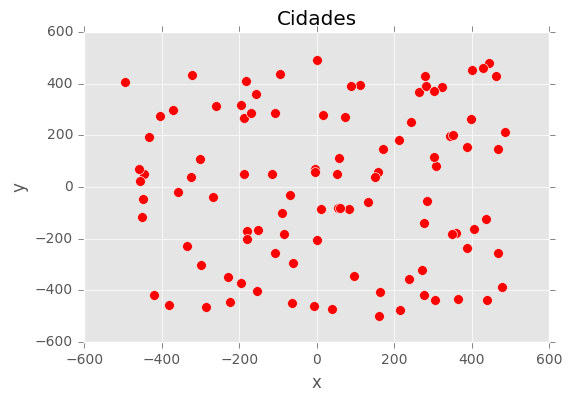

In [4]:
pd.DataFrame(data=Mapa, columns=['x', 'y']).plot(kind='scatter', x='x', y='y', s=50, color='red', title='Cidades');

### 2.3 Indivíduo e população

> "O Algoritmo Genético começa com um conjunto de $k = TAMANHO\_POPULACAO$ estados gerados aleatoriamente, chamado **população**. Cada estado, ou **indivíduo** é representado por uma cadeia sobre um alfabeto finito $A$."
> 
> — Adaptado de Inteligência Artificial – Uma abordagem moderna (2º Edição). Russel e Norvig

#### 2.3.1 Indivíduo

Nesta implementação de AG para o problema do Caxeiro Viajante, o alfabeto um indivídio $A$ é $$A = \{0, 1, ..., n-2, n-1\}, \mid n = TOTAL\_CIDADES$$, onde cada caractere do alfabeto possui uma correspondência com o índice de uma cidade no catálogo do mapa: o caractere $5$ do alfabeto corresponde à $Mapa[5]$, ou seja, a $6º$ cidade no catálogo do Mapa.

Resumindo: Um indivíduo é uma sequência de índices únicos.

#### 2.3.2 Percurso

Um indivíduo é composto por uma cadeia de caracteres do alfabeto $A$, contendo $n = TOTAL\_CIDADES$ caracteres únicos (sem repetição). Um indivíduo (estado) significa um percurso válido para o caxeiro viajante. Podemos descrever o **percurso** como uma travessia seguindo a sequência de cidades definidas pela cadeia de caracteres de um individuo. Como o caxeiro deve retornar ao local inicial no fim do trajeto, o percurso também conta o trajeto do último caractere da cadeia ao primeiro caractere.


```python
def percurso(individuo, Mapa):
    """
    Pseudo código para descrever um percurso definido por um indivíduo
    """
    for indice in range(TOTAL_CIDADES - 1): #[0..TOTAL_CIDADES-2]
        indice_cidade_1 = individuo[indice]
        indice_cidade_2 = individuo[indice+1]

        print(Mapa[indice_cidade_1], "->" Mapa[indice_cidade_2])
    
    # Indivíduo volta para a primeira cidade
    indice_cidade_1 = individuo[TOTAL_CIDADES-1]
    indice_cidade_2 = individuo[0]
    
    print(Mapa[indice_cidade_1], "->" Mapa[indice_cidade_1])
```

#### 2.3.3 Atributo fitness de um indivíduo

Em `deap` (a biblioteca utilizada), é necessário definir no indivíduo um atributo `fitness`, onde nele estará armazenado um objeto do tipo `base.Fitness`, que contém:
* O valor de fitness para um indivíduo (`individuo.fitness.values`);
* A informação se o fitness foi calculado para o indivíduo (`individuo.fitness.valid`);
* A descrição se queremos _minimizar_ o _maximizar_ o valor resultado da função de fitness para o indivíduo;

Como queremos _minimizar_ o fitness, é criado o `FitnessMinimo`, onde definimos um peso -1.0 (`weights=(-1.0,)`), definindo que queremos minimizar o valor calculado pela função de fitness.

**Observação:** Observe que `weights` recebe um iterável de pesos. Observe também que é `individuo.fitness.values`, e não `individuo.fitness.value`. A biblioteca `deap` permite trabalhar com diversos atributos simultaneamente. Podemos então, por exemplo, buscar resultados que minimizem um primeiro atributo e maximizem um segundo atributo, como visitar todas as cidades por  um caminho que seja o mais curto e que a ordem das cidades seja mais próxima à alfabética (as primeiras cidades devem tender a começar com A e as últimas começar com Z).

In [5]:
from deap import base, creator

# Criando tipos
#  http://deap.readthedocs.io/en/master/tutorials/basic/part1.html

# "creator" cria uma classe
#  name = Nome da classe
#  base = classe que a classe criada herdará (FitnessMinimo extends base.Fitness)
#  weights=(-1.0,): Minimizar primeiro atributo
#  weights=(-1.0, 1.0): Minimiza primeiro atributo, maximiza segundo atributo

# Função de avaliação fitness
creator.create(name="FitnessMinimo", base=base.Fitness, weights=(-1.0,))
creator.create(name="Individuo", base=list, fitness=creator.FitnessMinimo)

#################
# Exemplo
#################

print("Exemplo de indivíduo")
individuo = creator.Individuo([0, 1, 2, 3, 4])

print(' - Indivíduo:', individuo)
print(' - Tipo do objeto:', type(individuo))
print(' - Cidades correspondentes:', list(map(lambda indice_cidade: Mapa[indice_cidade], individuo)))
print(' - Percurso:', end='')
for indice_cidade in individuo:
    print(Mapa[indice_cidade], '->', end=' ')
print(Mapa[individuo[0]])
print(' - Fitness definido?', individuo.fitness.valid)
print(' - Valores do fitness:', individuo.fitness.values)
print(' - Pesos dos fitness:', individuo.fitness.weights)
individuo.fitness.values = (5,)
print(' - Fitness definido?', individuo.fitness.valid)
print(' - Valores do fitness:', individuo.fitness.values)

Exemplo de indivíduo
 - Indivíduo: [0, 1, 2, 3, 4]
 - Tipo do objeto: <class 'deap.creator.Individuo'>
 - Cidades correspondentes: [(-108, -255), (-195, 318), (-85, -182), (308, 81), (360, -178)]
 - Percurso:(-108, -255) -> (-195, 318) -> (-85, -182) -> (308, 81) -> (360, -178) -> (-108, -255)
 - Fitness definido? False
 - Valores do fitness: ()
 - Pesos dos fitness: (-1.0,)
 - Fitness definido? True
 - Valores do fitness: (5.0,)


#### 2.3.4 População

A seguir definiremos como:

* **Gerar indivíduos aleatórios**:
É utilizado a função `random.sample(population, k)`:
> Return a k length list of unique elements chosen from the population sequence. Used for random sampling without replacement.
* **Gerar uma população de indivíduos aleatórios**

In [6]:
from deap import tools

TAMANHO_INDIVIDUO = TOTAL_CIDADES

toolbox = base.Toolbox()

# Attribute generator

# Gerar indivíduos 
toolbox.register("indices", random.sample, range(TAMANHO_INDIVIDUO), TAMANHO_INDIVIDUO)
#  toolbox.individuo() consegue gerar deap.creator.Individuo através do generator=toolbox.indices
#  container = Tipo dos individuos a serem gerados
toolbox.register("individuo", tools.initIterate, container=creator.Individuo, generator=toolbox.indices)

# Gerar uma população de indivíduos aleatórios
toolbox.register("populacao", tools.initRepeat, list, toolbox.individuo)


#################
# Exemplo
#################
individuo = toolbox.individuo()
populacao = toolbox.populacao(n=3)

print("individuo é do tipo %s e contém %d elementos (genes)\n%s" % (type(individuo), len(individuo), individuo))
print("populacao é do tipo %s e contém %d indivíduos\n%s" % (type(populacao), len(populacao), populacao))

individuo é do tipo <class 'deap.creator.Individuo'> e contém 100 elementos (genes)
[63, 85, 22, 28, 35, 24, 80, 34, 46, 43, 42, 5, 77, 19, 37, 33, 1, 13, 40, 8, 10, 25, 91, 57, 82, 31, 49, 11, 94, 53, 95, 98, 3, 20, 68, 59, 23, 51, 83, 30, 71, 9, 7, 72, 52, 32, 75, 17, 84, 2, 38, 18, 21, 6, 48, 93, 64, 66, 54, 41, 36, 61, 16, 62, 78, 88, 58, 60, 69, 96, 39, 12, 50, 79, 14, 99, 47, 56, 89, 15, 86, 29, 73, 44, 87, 97, 76, 67, 92, 90, 0, 4, 45, 65, 55, 26, 74, 70, 27, 81]
populacao é do tipo <class 'list'> e contém 3 indivíduos
[[23, 82, 20, 66, 81, 91, 21, 92, 90, 44, 39, 85, 54, 31, 1, 79, 48, 16, 60, 10, 99, 3, 75, 43, 52, 14, 94, 15, 89, 17, 22, 93, 24, 4, 97, 33, 70, 34, 2, 96, 61, 64, 80, 41, 98, 47, 67, 19, 68, 26, 46, 56, 27, 11, 78, 72, 38, 63, 77, 49, 83, 71, 9, 0, 57, 30, 59, 51, 12, 45, 65, 53, 32, 74, 40, 36, 50, 62, 55, 7, 18, 58, 35, 28, 76, 6, 73, 29, 8, 86, 42, 95, 88, 13, 87, 25, 5, 69, 84, 37], [96, 15, 34, 97, 92, 73, 64, 95, 68, 43, 54, 32, 87, 39, 14, 12, 71, 85, 21

### 2.4 Função de avaliação ou de _fitness_

A função fitness, definida também como função de avaliação, calcula para um indivíduo passado a distância euclidiana de um percurso.
Ou seja, a distância euclidiana de percorer da primeira cidade de um percurso para a segunda, mais a distância euclidiana de percorrer da segunda cidade para a terceira, assim sucessivamente para todas as cidades do percurso.

A distância euclidiana por entre dois pontos ${\displaystyle P=(p_{x},p_{y})}$ e ${\displaystyle Q=(q_{x},q_{y})}$ é dada como $${\displaystyle {\sqrt {(p_{x}-q_{x})^{2}+(p_{y}-q_{y})^{2}}}.}$$

In [7]:
import math

def distancia_euclidiana(a, b):
    return math.sqrt((a[0]-b[0])**2 + (a[1]-b[1])**2)

def funcao_de_fitness(individuo):
    distancia = 0
    
    for gene1, gene2 in zip(individuo[0:-1], individuo[1:]):
        gene1 = Mapa[gene1]
        gene2 = Mapa[gene2]
        
        distancia += distancia_euclidiana(gene1, gene2)
    
    # Voltar para o caminho inicial
    gene1 = Mapa[0]
    gene2 = Mapa[-1]
    distancia += distancia_euclidiana(gene1, gene2)
    
    return distancia,

# Registrando a função de fitness
toolbox.register("evaluate", funcao_de_fitness)

################
# Exemplo
################
individuo = creator.Individuo(range(5))
print("Função avaliadora para o indivíduo", individuo)
print(" - Valor: ", funcao_de_fitness(individuo))

Função avaliadora para o indivíduo [0, 1, 2, 3, 4]
 - Valor:  (2052.041146440896,)


### 2.5 Mutação

Foi utilizado para a mutação `tools.mutShuffleIndexes(individual, indpb)`, que gera um mutante a partir de um indivíduo fazendo um _shuffle_ (alterando a ordem) nos atributos do indivíduo. Ou seja, alterando a ordem que o caxeiro visita as cidades.

É necessário especificar também a probabilidade de realizar um _shuffle_ em cada elemento (atributo `indpb`). A probabilidade escolhida foi $0.05$.

In [8]:
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)

################
# Exemplo
################
individuo = creator.Individuo(range(10))
probabilidade = 0.20  # Probabilidade maior pra demonstrar o shuffle

print('Exemplo com probabilidade', probabilidade)
print(' - Individuo:', individuo)
print(' - Probabilidade:', probabilidade)
print(' - Resultado:', tools.mutShuffleIndexes(individuo, indpb=probabilidade))

Exemplo com probabilidade 0.2
 - Individuo: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
 - Probabilidade: 0.2
 - Resultado: ([4, 1, 2, 3, 0, 5, 6, 9, 8, 7],)


### 2.6 Seleção

In [9]:
# Select k individuals from the input individuals using
# k tournaments of tournsize individuals.
# The list returned contains references to the input individuals.

toolbox.register("select", tools.selTournament, tournsize=3)

### 2.7 Cruzamento

Foi utilizado o cruzamento `tools.cxPartialyMatched(ind1, ind2)`

> Executes a partially matched crossover (PMX) on the input individuals. The two individuals are modified in place. This crossover expects sequence individuals of indices, the result for any other type of individuals is unpredictable.



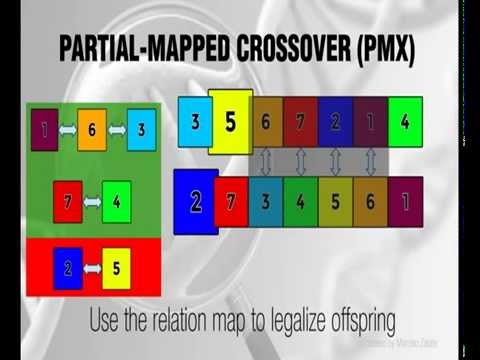

In [14]:
from IPython.display import YouTubeVideo
YouTubeVideo("c2ft8AG8JKE")

In [36]:
toolbox.register("mate", tools.cxPartialyMatched)

################
# Exemplo
################
individuo_1 = creator.Individuo(range(10))
individuo_2 = creator.Individuo(reversed(range(10)))

print("PMX")
print(" - Indivíduo 1", individuo_1)
print(" - Indivíduo 2", individuo_2)
print(" - Cruzamento PMX")
print("  ", tools.cxPartialyMatched(individuo_1, individuo_2))

PMX
 - Indivíduo 1 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
 - Indivíduo 2 [9, 8, 7, 6, 5, 4, 3, 2, 1, 0]
 - Cruzamento PMX
   ([0, 8, 2, 3, 4, 5, 6, 7, 1, 9], [9, 1, 7, 6, 5, 4, 3, 2, 8, 0])


## 3. Execução

São mostrados dois algoritmos para a execução: um que realiza os cálculos manualmente e outro que faz a evolução da população pela biblioteca $deap$.

### 3.1 Método 1 - Manual

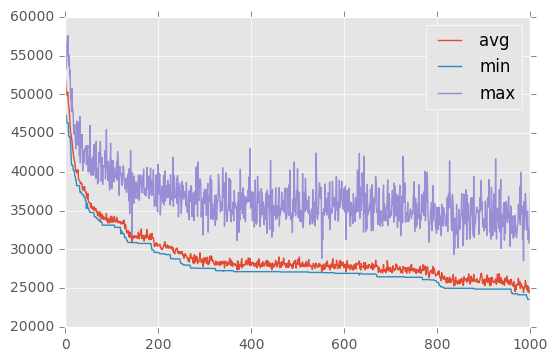

In [11]:
def main():
    populacao = toolbox.populacao(n=TAMANHO_POPULACAO)
    
    # Aplicar função de fitness para cada indivíduo
    calcular_fitness(populacao, toolbox.evaluate)
    valores = pd.Series(map(lambda individuo: individuo.fitness.values[0], populacao))
    
    historico = gerar_historico(populacao)

    for geracao in range(NUMERO_GERACOES):
        descendentes = selecionar_individuos_da_proxima_geracao(populacao)

        aplicar_cruzamento(descendentes)
        aplicar_mutacao(descendentes)

        # Avaliar os indivíduos que não foram avaliados (invalid fitness)
        # (sofreram mutação ou filhos de cruzamento)
        individuos_nao_avaliados = [individuo for individuo in descendentes if not individuo.fitness.valid]
        calcular_fitness(individuos_nao_avaliados, toolbox.evaluate)

        # Substituir elementos da população pelos descentendes
        populacao[:] = descendentes
        historico = gerar_historico(populacao, historico)

    return populacao, historico

def gerar_historico(populacao, dataframe=None):
    if dataframe is None:
        dataframe = pd.DataFrame(columns=['avg', 'min', 'max'])
    
    valores = pd.Series(map(lambda individuo: individuo.fitness.values[0], populacao))
        
    data = {
        'min': valores.min(),
        'max': valores.max(),
        'avg': valores.mean(),
    }

    return dataframe.append(data, ignore_index=True)

def selecionar_individuos_da_proxima_geracao(populacao):
    # Selecionar os indivíduos da próxima geração
    descendentes = toolbox.select(populacao, len(populacao))
    # Clonar os indivíduos selecionados
    return list(map(toolbox.clone, descendentes))

def aplicar_cruzamento(populacao):
    pares = populacao[::2]
    impares = populacao[1::2]

    for filho1, filho2 in zip(pares, impares):
        if random.random() < PROBABILIDADE_CRUZAMENTO:
            toolbox.mate(filho1, filho2)
            del filho1.fitness.values
            del filho2.fitness.values

def aplicar_mutacao(populacao):
    for mutant in populacao:
        if random.random() < PROBABILIDADE_MUTACAO:
            toolbox.mutate(mutant)
            del mutant.fitness.values

def calcular_fitness(populacao, funcao_avaliacao):
    """
    Aplica função de fitness para cada indivíduo
    de uma população
    """
    resultados_fitness = map(funcao_avaliacao, populacao)
    for individuo, fitness in zip(populacao, resultados_fitness):
        individuo.fitness.values = fitness

populacao_resultado, historico = main()
historico.plot()

### 3.2 Método 2 - Utilizando `deap`

Best individual is: [74, 13, 32, 26, 47, 81, 24, 90, 33, 97, 79, 25, 89, 83, 93, 52, 50, 14, 76, 66, 16, 64, 78, 86, 75, 22, 42, 19, 82, 27, 3, 91, 87, 29, 56, 20, 49, 44, 99, 0, 17, 40, 36, 7, 12, 21, 84, 96, 34, 23, 10, 39, 37, 45, 53, 15, 2, 30, 18, 6, 94, 98, 46, 5, 80, 62, 1, 43, 71, 59, 70, 57, 88, 35, 28, 68, 60, 55, 9, 63, 92, 11, 31, 8, 69, 48, 61, 77, 4, 85, 51, 73, 95, 72, 41, 58, 65, 67, 38, 54]
with fitness: (24322.896214277138,)


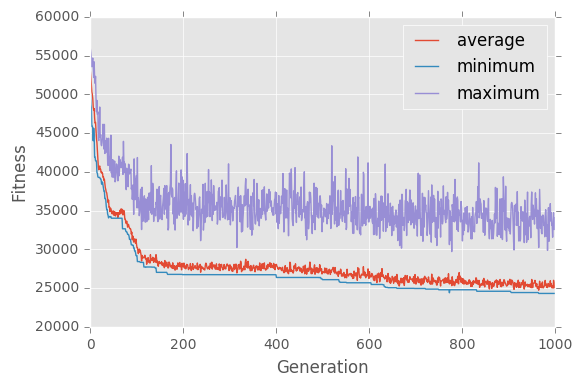

In [12]:
from deap import algorithms
toolbox.register("population", tools.initRepeat, list, toolbox.individuo)

def xd():
    import numpy
    
    pop = toolbox.population(n=TAMANHO_POPULACAO)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", numpy.mean)
    stats.register("min", numpy.min)
    stats.register("max", numpy.max)
    
    populacao, logbook = algorithms.eaSimple(
        pop,
        toolbox,
        cxpb=PROBABILIDADE_CRUZAMENTO,
        mutpb=PROBABILIDADE_MUTACAO,
        ngen=NUMERO_GERACOES,
        stats=stats,
        halloffame=hof,
        verbose=False
    )
    
    return algorithms, logbook, hof

pop, log, hof = xd()
print("Best individual is: %s\nwith fitness: %s" % (hof[0], hof[0].fitness))

import matplotlib.pyplot as plt
gen, avg, min_, max_ = log.select("gen", "avg", "min", "max")
plt.plot(gen, avg, label="average")
plt.plot(gen, min_, label="minimum")
plt.plot(gen, max_, label="maximum")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend(loc="best")
plt.show()